In [69]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import struct
import os
from tqdm import tqdm
from tqdm import trange
from tensorflow.python.client import device_lib

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Training Parameters
learning_rate = 0.01
train_epochs = 40
batch_size = 5000

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features
num_hidden_3 = 64 # 3rd layer num features
num_input = 784 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'encoder_h3': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_3])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_3, num_hidden_2])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h3': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'encoder_b3': tf.Variable(tf.random_normal([num_hidden_3])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b2': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b3': tf.Variable(tf.random_normal([num_input])),
}

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [70]:
def load_mnist_train(path, kind='train'): 
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)
    with open(images_path, 'rb') as imgpath: 
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16)) 
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)
    
    return images, labels

In [71]:
def load_mnist_test(path, kind='t10k'): 
    labels_path = os.path.join(path,'%s-labels.idx1-ubyte'% kind) 
    images_path = os.path.join(path,'%s-images.idx3-ubyte'% kind) 
    with open(labels_path, 'rb') as lbpath: 
        magic, n = struct.unpack('>II',lbpath.read(8)) 
        labels = np.fromfile(lbpath,dtype=np.uint8) 
    with open(images_path, 'rb') as imgpath: 
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16)) 
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)
    
    return images, labels

In [72]:
path = os.getcwd()
train_images, train_labels = load_mnist_train(path)
test_images, test_labels = load_mnist_test(path)
print(len(train_images))

60000


In [73]:
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                                   biases['encoder_b3']), name = 'feature')
    return layer_3


In [74]:
# Building the decoder
def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    # Decoder Hidden layer with sigmoid activation #3
    layer_3 = tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                                biases['decoder_b3'])
    return layer_3

In [75]:
def check_available_gpus():
    local_devices = device_lib.list_local_devices()
    gpu_names = [x.name for x in device_lib.list_local_devices() if x.device_type == 'GPU']
    gpu_num = len(gpu_names)
    print('{0} GPUs are detected : {1}'.format(gpu_num, gpu_names))
    return gpu_num

In [76]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X
#Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true- y_pred,2),name = 'loss')
#loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
saver = tf.train.Saver()
check_available_gpus()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

1 GPUs are detected : ['/device:GPU:0']


In [85]:
if not os.path.exists('tmpnn/'):
    os.mkdir('tmpnn/')
with tf.Session() as sess:
    if os.path.exists('tmpnn/checkpoint'):
        saver.restore(sess, 'tmpnn/model.ckpt')
    else:
        sess.run(tf.global_variables_initializer())
    total_batch  = int(len(train_images)/batch_size)
    min_lose = float('inf')
    for e in range(train_epochs):    
        for b in tqdm(range(total_batch)):
            batch = train_images[b*batch_size:(b+1)*batch_size]
            imgs = batch.reshape((-1,28,28,1))
            batch_cost, _=sess.run([loss, optimizer],feed_dict={X:batch})
            msg = "Global Step={:d}, Local batch={:d}, lose={:.4f}"
            if(batch_cost<min_lose):
                min_lose = batch_cost
                saver.save(sess, 'tmpnn/model.ckpt')
            print(msg.format(e,b,batch_cost))
    

INFO:tensorflow:Restoring parameters from tmpnn/model.ckpt


 58%|█████▊    | 7/12 [00:00<00:02,  2.04it/s]

Global Step=0, Local batch=0, lose=1561.1697
Global Step=0, Local batch=1, lose=1577.2706
Global Step=0, Local batch=2, lose=1595.1002
Global Step=0, Local batch=3, lose=1599.4235
Global Step=0, Local batch=4, lose=1599.3242
Global Step=0, Local batch=5, lose=1586.1747
Global Step=0, Local batch=6, lose=1584.2407
Global Step=0, Local batch=7, lose=1607.0745
Global Step=0, Local batch=8, lose=1599.3485
Global Step=0, Local batch=9, lose=1646.8267
Global Step=0, Local batch=10, lose=1577.0552


 42%|████▏     | 5/12 [00:00<00:00, 48.85it/s]

Global Step=0, Local batch=11, lose=1568.2500
Global Step=1, Local batch=0, lose=1565.9595
Global Step=1, Local batch=1, lose=1575.0962
Global Step=1, Local batch=2, lose=1589.0576
Global Step=1, Local batch=3, lose=1593.3573
Global Step=1, Local batch=4, lose=1591.2516
Global Step=1, Local batch=5, lose=1581.7976
Global Step=1, Local batch=6, lose=1582.3297
Global Step=1, Local batch=7, lose=1596.2161
Global Step=1, Local batch=8, lose=1588.5531
Global Step=1, Local batch=9, lose=1639.3798


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=1, Local batch=10, lose=1572.5474
Global Step=1, Local batch=11, lose=1561.8735


 58%|█████▊    | 7/12 [00:00<00:01,  2.69it/s]

Global Step=2, Local batch=0, lose=1556.1335
Global Step=2, Local batch=1, lose=1569.5959
Global Step=2, Local batch=2, lose=1597.4474
Global Step=2, Local batch=3, lose=1609.9744
Global Step=2, Local batch=4, lose=1614.0360
Global Step=2, Local batch=5, lose=1597.6951
Global Step=2, Local batch=6, lose=1581.3054
Global Step=2, Local batch=7, lose=1603.8787
Global Step=2, Local batch=8, lose=1611.4387
Global Step=2, Local batch=9, lose=1651.7721
Global Step=2, Local batch=10, lose=1578.5343


 50%|█████     | 6/12 [00:00<00:00, 51.68it/s]

Global Step=2, Local batch=11, lose=1568.7048
Global Step=3, Local batch=0, lose=1566.0249
Global Step=3, Local batch=1, lose=1579.8502
Global Step=3, Local batch=2, lose=1592.3396
Global Step=3, Local batch=3, lose=1588.6270
Global Step=3, Local batch=4, lose=1584.5946
Global Step=3, Local batch=5, lose=1576.9318
Global Step=3, Local batch=6, lose=1581.5474
Global Step=3, Local batch=7, lose=1601.9084
Global Step=3, Local batch=8, lose=1594.4169
Global Step=3, Local batch=9, lose=1629.3945


 50%|█████     | 6/12 [00:00<00:00, 54.32it/s]

Global Step=3, Local batch=10, lose=1562.4877
Global Step=3, Local batch=11, lose=1569.5295
Global Step=4, Local batch=0, lose=1566.7478
Global Step=4, Local batch=1, lose=1565.0525
Global Step=4, Local batch=2, lose=1585.5143
Global Step=4, Local batch=3, lose=1591.2863
Global Step=4, Local batch=4, lose=1583.7948
Global Step=4, Local batch=5, lose=1573.5762
Global Step=4, Local batch=6, lose=1582.9430
Global Step=4, Local batch=7, lose=1596.6860
Global Step=4, Local batch=8, lose=1584.0126


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=4, Local batch=9, lose=1627.2854
Global Step=4, Local batch=10, lose=1565.5662
Global Step=4, Local batch=11, lose=1561.2318


 58%|█████▊    | 7/12 [00:00<00:01,  2.67it/s]

Global Step=5, Local batch=0, lose=1552.9109
Global Step=5, Local batch=1, lose=1563.7009
Global Step=5, Local batch=2, lose=1584.3252
Global Step=5, Local batch=3, lose=1581.3856
Global Step=5, Local batch=4, lose=1586.0580
Global Step=5, Local batch=5, lose=1572.0127
Global Step=5, Local batch=6, lose=1572.5565
Global Step=5, Local batch=7, lose=1590.7706
Global Step=5, Local batch=8, lose=1584.1423
Global Step=5, Local batch=9, lose=1621.3958
Global Step=5, Local batch=10, lose=1557.0856
Global Step=5, Local batch=11, lose=1557.6346


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=6, Local batch=0, lose=1547.3334
Global Step=6, Local batch=1, lose=1556.6763
Global Step=6, Local batch=2, lose=1583.4709
Global Step=6, Local batch=3, lose=1580.8411
Global Step=6, Local batch=4, lose=1587.1033
Global Step=6, Local batch=5, lose=1576.6080
Global Step=6, Local batch=6, lose=1569.9180
Global Step=6, Local batch=7, lose=1592.1777
Global Step=6, Local batch=8, lose=1587.1979
Global Step=6, Local batch=9, lose=1624.0536
Global Step=6, Local batch=10, lose=1558.4974
Global Step=6, Local batch=11, lose=1554.3289


 58%|█████▊    | 7/12 [00:00<00:01,  3.11it/s]

Global Step=7, Local batch=0, lose=1547.1809
Global Step=7, Local batch=1, lose=1557.6874
Global Step=7, Local batch=2, lose=1578.4189
Global Step=7, Local batch=3, lose=1582.3431
Global Step=7, Local batch=4, lose=1595.8221
Global Step=7, Local batch=5, lose=1581.7129
Global Step=7, Local batch=6, lose=1571.7019
Global Step=7, Local batch=7, lose=1588.2107
Global Step=7, Local batch=8, lose=1581.3351
Global Step=7, Local batch=9, lose=1629.7917
Global Step=7, Local batch=10, lose=1560.8132


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=7, Local batch=11, lose=1546.2124


 58%|█████▊    | 7/12 [00:00<00:01,  2.84it/s]

Global Step=8, Local batch=0, lose=1545.8677
Global Step=8, Local batch=1, lose=1557.1071
Global Step=8, Local batch=2, lose=1574.2750
Global Step=8, Local batch=3, lose=1582.0631
Global Step=8, Local batch=4, lose=1579.4784
Global Step=8, Local batch=5, lose=1559.4464
Global Step=8, Local batch=6, lose=1567.6324
Global Step=8, Local batch=7, lose=1588.4811
Global Step=8, Local batch=8, lose=1579.5543
Global Step=8, Local batch=9, lose=1620.2733
Global Step=8, Local batch=10, lose=1547.7295


 50%|█████     | 6/12 [00:00<00:00, 53.32it/s]

Global Step=8, Local batch=11, lose=1551.0001
Global Step=9, Local batch=0, lose=1550.3799
Global Step=9, Local batch=1, lose=1553.7146
Global Step=9, Local batch=2, lose=1573.8099
Global Step=9, Local batch=3, lose=1576.4531
Global Step=9, Local batch=4, lose=1575.9485
Global Step=9, Local batch=5, lose=1564.3933
Global Step=9, Local batch=6, lose=1567.2472
Global Step=9, Local batch=7, lose=1576.0881
Global Step=9, Local batch=8, lose=1574.7863
Global Step=9, Local batch=9, lose=1623.0554


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=9, Local batch=10, lose=1555.1598
Global Step=9, Local batch=11, lose=1547.9463


 58%|█████▊    | 7/12 [00:00<00:01,  2.87it/s]

Global Step=10, Local batch=0, lose=1542.1425
Global Step=10, Local batch=1, lose=1549.7101
Global Step=10, Local batch=2, lose=1573.1295
Global Step=10, Local batch=3, lose=1568.3660
Global Step=10, Local batch=4, lose=1564.2086
Global Step=10, Local batch=5, lose=1555.8855
Global Step=10, Local batch=6, lose=1557.3175
Global Step=10, Local batch=7, lose=1575.1409
Global Step=10, Local batch=8, lose=1569.6088
Global Step=10, Local batch=9, lose=1607.0586


 92%|█████████▏| 11/12 [00:01<00:00,  3.50it/s]

Global Step=10, Local batch=10, lose=1541.8688


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=10, Local batch=11, lose=1539.3445


 58%|█████▊    | 7/12 [00:00<00:01,  3.02it/s]

Global Step=11, Local batch=0, lose=1531.8676
Global Step=11, Local batch=1, lose=1543.6656
Global Step=11, Local batch=2, lose=1562.7993
Global Step=11, Local batch=3, lose=1564.7222
Global Step=11, Local batch=4, lose=1571.2336
Global Step=11, Local batch=5, lose=1559.3508
Global Step=11, Local batch=6, lose=1564.3550
Global Step=11, Local batch=7, lose=1579.3695
Global Step=11, Local batch=8, lose=1565.1689
Global Step=11, Local batch=9, lose=1611.1024
Global Step=11, Local batch=10, lose=1547.6012


 50%|█████     | 6/12 [00:00<00:00, 52.08it/s]

Global Step=11, Local batch=11, lose=1541.2321
Global Step=12, Local batch=0, lose=1533.0176
Global Step=12, Local batch=1, lose=1540.0408
Global Step=12, Local batch=2, lose=1560.8427
Global Step=12, Local batch=3, lose=1565.4323
Global Step=12, Local batch=4, lose=1571.7908
Global Step=12, Local batch=5, lose=1569.0674
Global Step=12, Local batch=6, lose=1579.2307
Global Step=12, Local batch=7, lose=1590.3044
Global Step=12, Local batch=8, lose=1568.3594
Global Step=12, Local batch=9, lose=1609.4291


 50%|█████     | 6/12 [00:00<00:00, 49.74it/s]

Global Step=12, Local batch=10, lose=1549.6830
Global Step=12, Local batch=11, lose=1542.3535
Global Step=13, Local batch=0, lose=1533.6250
Global Step=13, Local batch=1, lose=1551.8036
Global Step=13, Local batch=2, lose=1575.5762
Global Step=13, Local batch=3, lose=1578.1193
Global Step=13, Local batch=4, lose=1572.3374
Global Step=13, Local batch=5, lose=1553.2578
Global Step=13, Local batch=6, lose=1561.3596
Global Step=13, Local batch=7, lose=1579.8259


 50%|█████     | 6/12 [00:00<00:00, 53.04it/s]

Global Step=13, Local batch=8, lose=1567.7688
Global Step=13, Local batch=9, lose=1605.9775
Global Step=13, Local batch=10, lose=1550.7769
Global Step=13, Local batch=11, lose=1552.7380
Global Step=14, Local batch=0, lose=1539.7068
Global Step=14, Local batch=1, lose=1538.8488
Global Step=14, Local batch=2, lose=1559.1453
Global Step=14, Local batch=3, lose=1571.9152
Global Step=14, Local batch=4, lose=1575.5406
Global Step=14, Local batch=5, lose=1565.9292
Global Step=14, Local batch=6, lose=1563.7928
Global Step=14, Local batch=7, lose=1571.8065


 50%|█████     | 6/12 [00:00<00:00, 51.69it/s]

Global Step=14, Local batch=8, lose=1563.3279
Global Step=14, Local batch=9, lose=1619.2887
Global Step=14, Local batch=10, lose=1551.6432
Global Step=14, Local batch=11, lose=1533.0020
Global Step=15, Local batch=0, lose=1533.7654
Global Step=15, Local batch=1, lose=1552.1083
Global Step=15, Local batch=2, lose=1562.2770
Global Step=15, Local batch=3, lose=1560.5844
Global Step=15, Local batch=4, lose=1559.7744
Global Step=15, Local batch=5, lose=1548.5765
Global Step=15, Local batch=6, lose=1551.7716
Global Step=15, Local batch=7, lose=1574.8431
Global Step=15, Local batch=8, lose=1561.4856
Global Step=15, Local batch=9, lose=1596.5768
Global Step=15, Local batch=10, lose=1536.8296


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=15, Local batch=11, lose=1531.5590


 58%|█████▊    | 7/12 [00:00<00:01,  2.93it/s]

Global Step=16, Local batch=0, lose=1530.5759
Global Step=16, Local batch=1, lose=1539.3615
Global Step=16, Local batch=2, lose=1555.8706
Global Step=16, Local batch=3, lose=1562.4644
Global Step=16, Local batch=4, lose=1551.3629
Global Step=16, Local batch=5, lose=1542.0116
Global Step=16, Local batch=6, lose=1553.9318
Global Step=16, Local batch=7, lose=1565.5817
Global Step=16, Local batch=8, lose=1553.3942
Global Step=16, Local batch=9, lose=1594.6785


 92%|█████████▏| 11/12 [00:01<00:00,  3.58it/s]

Global Step=16, Local batch=10, lose=1529.3619


 50%|█████     | 6/12 [00:00<00:00, 55.09it/s]

Global Step=16, Local batch=11, lose=1527.8665
Global Step=17, Local batch=0, lose=1531.4194
Global Step=17, Local batch=1, lose=1538.6096
Global Step=17, Local batch=2, lose=1545.1290
Global Step=17, Local batch=3, lose=1549.9658
Global Step=17, Local batch=4, lose=1544.4589
Global Step=17, Local batch=5, lose=1532.8330
Global Step=17, Local batch=6, lose=1538.4270
Global Step=17, Local batch=7, lose=1553.0551
Global Step=17, Local batch=8, lose=1539.9329
Global Step=17, Local batch=9, lose=1585.4285


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=17, Local batch=10, lose=1518.5787
Global Step=17, Local batch=11, lose=1519.9839


 58%|█████▊    | 7/12 [00:00<00:01,  3.01it/s]

Global Step=18, Local batch=0, lose=1516.1423
Global Step=18, Local batch=1, lose=1523.8213
Global Step=18, Local batch=2, lose=1541.6168
Global Step=18, Local batch=3, lose=1547.8676
Global Step=18, Local batch=4, lose=1543.3590
Global Step=18, Local batch=5, lose=1534.4385
Global Step=18, Local batch=6, lose=1537.3102
Global Step=18, Local batch=7, lose=1549.6049
Global Step=18, Local batch=8, lose=1545.4426
Global Step=18, Local batch=9, lose=1589.3197


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=18, Local batch=10, lose=1515.8370
Global Step=18, Local batch=11, lose=1517.9918


 58%|█████▊    | 7/12 [00:00<00:01,  2.72it/s]

Global Step=19, Local batch=0, lose=1512.6881
Global Step=19, Local batch=1, lose=1523.1132
Global Step=19, Local batch=2, lose=1545.3151
Global Step=19, Local batch=3, lose=1547.0204
Global Step=19, Local batch=4, lose=1544.8142
Global Step=19, Local batch=5, lose=1540.1138
Global Step=19, Local batch=6, lose=1537.2185
Global Step=19, Local batch=7, lose=1543.4613
Global Step=19, Local batch=8, lose=1541.8733
Global Step=19, Local batch=9, lose=1584.9172
Global Step=19, Local batch=10, lose=1517.4780


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=19, Local batch=11, lose=1515.0668


 50%|█████     | 6/12 [00:00<00:02,  2.90it/s]

Global Step=20, Local batch=0, lose=1505.9812
Global Step=20, Local batch=1, lose=1521.0223
Global Step=20, Local batch=2, lose=1541.4825
Global Step=20, Local batch=3, lose=1544.2494
Global Step=20, Local batch=4, lose=1547.4163
Global Step=20, Local batch=5, lose=1543.5726
Global Step=20, Local batch=6, lose=1536.4459
Global Step=20, Local batch=7, lose=1541.4873
Global Step=20, Local batch=8, lose=1541.3024
Global Step=20, Local batch=9, lose=1588.0322


 50%|█████     | 6/12 [00:00<00:00, 52.60it/s]

Global Step=20, Local batch=10, lose=1518.1158
Global Step=20, Local batch=11, lose=1511.8896
Global Step=21, Local batch=0, lose=1507.7223
Global Step=21, Local batch=1, lose=1522.6525
Global Step=21, Local batch=2, lose=1542.3984
Global Step=21, Local batch=3, lose=1540.8369
Global Step=21, Local batch=4, lose=1539.3749
Global Step=21, Local batch=5, lose=1534.3558
Global Step=21, Local batch=6, lose=1538.9005
Global Step=21, Local batch=7, lose=1548.8823
Global Step=21, Local batch=8, lose=1540.7002


 50%|█████     | 6/12 [00:00<00:00, 55.86it/s]

Global Step=21, Local batch=9, lose=1579.9381
Global Step=21, Local batch=10, lose=1514.7871
Global Step=21, Local batch=11, lose=1518.5125
Global Step=22, Local batch=0, lose=1513.7787
Global Step=22, Local batch=1, lose=1522.8734
Global Step=22, Local batch=2, lose=1541.9105
Global Step=22, Local batch=3, lose=1540.0199
Global Step=22, Local batch=4, lose=1541.8718
Global Step=22, Local batch=5, lose=1538.9561
Global Step=22, Local batch=6, lose=1538.5631
Global Step=22, Local batch=7, lose=1544.6965
Global Step=22, Local batch=8, lose=1537.1686


 50%|█████     | 6/12 [00:00<00:00, 53.22it/s]

Global Step=22, Local batch=9, lose=1580.9109
Global Step=22, Local batch=10, lose=1513.7258
Global Step=22, Local batch=11, lose=1513.8818
Global Step=23, Local batch=0, lose=1507.5918
Global Step=23, Local batch=1, lose=1523.2778
Global Step=23, Local batch=2, lose=1542.5714
Global Step=23, Local batch=3, lose=1542.4531
Global Step=23, Local batch=4, lose=1548.9075
Global Step=23, Local batch=5, lose=1545.0549
Global Step=23, Local batch=6, lose=1543.3878
Global Step=23, Local batch=7, lose=1539.8501


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=23, Local batch=8, lose=1538.9548
Global Step=23, Local batch=9, lose=1598.8383
Global Step=23, Local batch=10, lose=1533.8120
Global Step=23, Local batch=11, lose=1512.1283


 58%|█████▊    | 7/12 [00:00<00:02,  2.01it/s]

Global Step=24, Local batch=0, lose=1501.5671
Global Step=24, Local batch=1, lose=1526.2515
Global Step=24, Local batch=2, lose=1551.1213
Global Step=24, Local batch=3, lose=1544.0916
Global Step=24, Local batch=4, lose=1532.1176
Global Step=24, Local batch=5, lose=1517.0189
Global Step=24, Local batch=6, lose=1529.6674
Global Step=24, Local batch=7, lose=1553.9159
Global Step=24, Local batch=8, lose=1542.1519
Global Step=24, Local batch=9, lose=1573.3901
Global Step=24, Local batch=10, lose=1509.2726


 50%|█████     | 6/12 [00:00<00:00, 55.67it/s]

Global Step=24, Local batch=11, lose=1513.8501
Global Step=25, Local batch=0, lose=1510.2039
Global Step=25, Local batch=1, lose=1522.0194
Global Step=25, Local batch=2, lose=1538.5909
Global Step=25, Local batch=3, lose=1526.9792
Global Step=25, Local batch=4, lose=1523.9684
Global Step=25, Local batch=5, lose=1529.8596
Global Step=25, Local batch=6, lose=1533.7988
Global Step=25, Local batch=7, lose=1536.2588
Global Step=25, Local batch=8, lose=1538.8755
Global Step=25, Local batch=9, lose=1577.1771
Global Step=25, Local batch=10, lose=1507.2273


 50%|█████     | 6/12 [00:00<00:00, 56.36it/s]

Global Step=25, Local batch=11, lose=1513.3683
Global Step=26, Local batch=0, lose=1506.4940
Global Step=26, Local batch=1, lose=1505.7251
Global Step=26, Local batch=2, lose=1527.3284
Global Step=26, Local batch=3, lose=1529.6785
Global Step=26, Local batch=4, lose=1528.8466
Global Step=26, Local batch=5, lose=1517.7462
Global Step=26, Local batch=6, lose=1518.7169
Global Step=26, Local batch=7, lose=1532.5770
Global Step=26, Local batch=8, lose=1530.8831
Global Step=26, Local batch=9, lose=1574.7510
Global Step=26, Local batch=10, lose=1503.0277


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=26, Local batch=11, lose=1498.7363


 58%|█████▊    | 7/12 [00:00<00:01,  2.90it/s]

Global Step=27, Local batch=0, lose=1495.9812
Global Step=27, Local batch=1, lose=1504.0940
Global Step=27, Local batch=2, lose=1523.1635
Global Step=27, Local batch=3, lose=1523.5988
Global Step=27, Local batch=4, lose=1523.6698
Global Step=27, Local batch=5, lose=1513.0254
Global Step=27, Local batch=6, lose=1512.5769
Global Step=27, Local batch=7, lose=1527.2103
Global Step=27, Local batch=8, lose=1529.6117
Global Step=27, Local batch=9, lose=1572.3474
Global Step=27, Local batch=10, lose=1500.3793


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=27, Local batch=11, lose=1495.5385


 58%|█████▊    | 7/12 [00:00<00:01,  2.86it/s]

Global Step=28, Local batch=0, lose=1494.9032
Global Step=28, Local batch=1, lose=1507.3765
Global Step=28, Local batch=2, lose=1526.3721
Global Step=28, Local batch=3, lose=1527.1948
Global Step=28, Local batch=4, lose=1524.4714
Global Step=28, Local batch=5, lose=1515.3425
Global Step=28, Local batch=6, lose=1511.0204
Global Step=28, Local batch=7, lose=1527.5719
Global Step=28, Local batch=8, lose=1532.2823
Global Step=28, Local batch=9, lose=1574.5074
Global Step=28, Local batch=10, lose=1501.1268


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=28, Local batch=11, lose=1499.9456


 58%|█████▊    | 7/12 [00:00<00:01,  2.80it/s]

Global Step=29, Local batch=0, lose=1493.2517
Global Step=29, Local batch=1, lose=1503.7043
Global Step=29, Local batch=2, lose=1523.8208
Global Step=29, Local batch=3, lose=1518.1305
Global Step=29, Local batch=4, lose=1516.9858
Global Step=29, Local batch=5, lose=1507.9233
Global Step=29, Local batch=6, lose=1509.4650
Global Step=29, Local batch=7, lose=1531.1997
Global Step=29, Local batch=8, lose=1528.4478
Global Step=29, Local batch=9, lose=1564.8029
Global Step=29, Local batch=10, lose=1493.4927


 50%|█████     | 6/12 [00:00<00:00, 54.17it/s]

Global Step=29, Local batch=11, lose=1494.3126
Global Step=30, Local batch=0, lose=1494.2966
Global Step=30, Local batch=1, lose=1505.0737
Global Step=30, Local batch=2, lose=1522.7587
Global Step=30, Local batch=3, lose=1519.0450
Global Step=30, Local batch=4, lose=1515.5021
Global Step=30, Local batch=5, lose=1508.7380
Global Step=30, Local batch=6, lose=1513.1978
Global Step=30, Local batch=7, lose=1532.9357
Global Step=30, Local batch=8, lose=1537.0613
Global Step=30, Local batch=9, lose=1573.8271


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=30, Local batch=10, lose=1496.9956
Global Step=30, Local batch=11, lose=1493.3058


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=31, Local batch=0, lose=1489.1718
Global Step=31, Local batch=1, lose=1502.2683
Global Step=31, Local batch=2, lose=1520.0892
Global Step=31, Local batch=3, lose=1519.4290
Global Step=31, Local batch=4, lose=1518.8900
Global Step=31, Local batch=5, lose=1517.6364
Global Step=31, Local batch=6, lose=1518.1993
Global Step=31, Local batch=7, lose=1527.9332
Global Step=31, Local batch=8, lose=1523.9302
Global Step=31, Local batch=9, lose=1563.7329
Global Step=31, Local batch=10, lose=1496.6763
Global Step=31, Local batch=11, lose=1497.2715


100%|██████████| 12/12 [00:00<00:00, 54.20it/s]

Global Step=32, Local batch=0, lose=1492.5425
Global Step=32, Local batch=1, lose=1501.7639
Global Step=32, Local batch=2, lose=1516.7601
Global Step=32, Local batch=3, lose=1517.8705
Global Step=32, Local batch=4, lose=1521.9098
Global Step=32, Local batch=5, lose=1515.5886
Global Step=32, Local batch=6, lose=1508.5397
Global Step=32, Local batch=7, lose=1520.1500
Global Step=32, Local batch=8, lose=1519.7196
Global Step=32, Local batch=9, lose=1563.3060
Global Step=32, Local batch=10, lose=1496.5929
Global Step=32, Local batch=11, lose=1493.1935



 58%|█████▊    | 7/12 [00:00<00:01,  2.98it/s]

Global Step=33, Local batch=0, lose=1483.7203
Global Step=33, Local batch=1, lose=1488.7124
Global Step=33, Local batch=2, lose=1508.6268
Global Step=33, Local batch=3, lose=1508.5674
Global Step=33, Local batch=4, lose=1513.9333
Global Step=33, Local batch=5, lose=1506.1357
Global Step=33, Local batch=6, lose=1501.9077
Global Step=33, Local batch=7, lose=1514.2023
Global Step=33, Local batch=8, lose=1509.1024
Global Step=33, Local batch=9, lose=1553.8274
Global Step=33, Local batch=10, lose=1487.5758


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=33, Local batch=11, lose=1486.7648


 58%|█████▊    | 7/12 [00:00<00:01,  3.05it/s]

Global Step=34, Local batch=0, lose=1479.9851
Global Step=34, Local batch=1, lose=1489.4707
Global Step=34, Local batch=2, lose=1511.7352
Global Step=34, Local batch=3, lose=1513.8872
Global Step=34, Local batch=4, lose=1521.3474
Global Step=34, Local batch=5, lose=1514.9681
Global Step=34, Local batch=6, lose=1510.7529
Global Step=34, Local batch=7, lose=1515.2249
Global Step=34, Local batch=8, lose=1508.5604
Global Step=34, Local batch=9, lose=1555.4833
Global Step=34, Local batch=10, lose=1489.1505


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=34, Local batch=11, lose=1484.3821


 58%|█████▊    | 7/12 [00:00<00:01,  2.91it/s]

Global Step=35, Local batch=0, lose=1474.4648
Global Step=35, Local batch=1, lose=1484.6064
Global Step=35, Local batch=2, lose=1507.3397
Global Step=35, Local batch=3, lose=1507.9193
Global Step=35, Local batch=4, lose=1511.2218
Global Step=35, Local batch=5, lose=1501.6443
Global Step=35, Local batch=6, lose=1497.3088
Global Step=35, Local batch=7, lose=1512.5936
Global Step=35, Local batch=8, lose=1514.3392
Global Step=35, Local batch=9, lose=1563.3597
Global Step=35, Local batch=10, lose=1494.4933


 50%|█████     | 6/12 [00:00<00:00, 54.13it/s]

Global Step=35, Local batch=11, lose=1487.9603
Global Step=36, Local batch=0, lose=1476.0477
Global Step=36, Local batch=1, lose=1487.1300
Global Step=36, Local batch=2, lose=1508.1490
Global Step=36, Local batch=3, lose=1504.9794
Global Step=36, Local batch=4, lose=1508.6737
Global Step=36, Local batch=5, lose=1495.9540
Global Step=36, Local batch=6, lose=1496.0254
Global Step=36, Local batch=7, lose=1516.0930
Global Step=36, Local batch=8, lose=1508.8529
Global Step=36, Local batch=9, lose=1549.7179


 50%|█████     | 6/12 [00:00<00:00, 55.11it/s]

Global Step=36, Local batch=10, lose=1484.8787
Global Step=36, Local batch=11, lose=1482.5040
Global Step=37, Local batch=0, lose=1478.9502
Global Step=37, Local batch=1, lose=1491.2516
Global Step=37, Local batch=2, lose=1508.4706
Global Step=37, Local batch=3, lose=1511.9445
Global Step=37, Local batch=4, lose=1509.8358
Global Step=37, Local batch=5, lose=1499.3595
Global Step=37, Local batch=6, lose=1504.1948
Global Step=37, Local batch=7, lose=1515.4874
Global Step=37, Local batch=8, lose=1506.0076


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=37, Local batch=9, lose=1553.5731
Global Step=37, Local batch=10, lose=1479.9371
Global Step=37, Local batch=11, lose=1478.5308


 58%|█████▊    | 7/12 [00:00<00:01,  2.90it/s]

Global Step=38, Local batch=0, lose=1473.1815
Global Step=38, Local batch=1, lose=1482.8246
Global Step=38, Local batch=2, lose=1501.9747
Global Step=38, Local batch=3, lose=1503.6373
Global Step=38, Local batch=4, lose=1498.5764
Global Step=38, Local batch=5, lose=1498.4182
Global Step=38, Local batch=6, lose=1504.4108
Global Step=38, Local batch=7, lose=1513.2855
Global Step=38, Local batch=8, lose=1507.7412
Global Step=38, Local batch=9, lose=1548.7725
Global Step=38, Local batch=10, lose=1475.9601


 50%|█████     | 6/12 [00:00<00:00, 55.13it/s]

Global Step=38, Local batch=11, lose=1485.1295
Global Step=39, Local batch=0, lose=1474.2827
Global Step=39, Local batch=1, lose=1480.2504
Global Step=39, Local batch=2, lose=1503.2197
Global Step=39, Local batch=3, lose=1500.8429
Global Step=39, Local batch=4, lose=1501.5317
Global Step=39, Local batch=5, lose=1504.6124
Global Step=39, Local batch=6, lose=1501.2383
Global Step=39, Local batch=7, lose=1512.6506
Global Step=39, Local batch=8, lose=1506.0930
Global Step=39, Local batch=9, lose=1546.9065


100%|██████████| 12/12 [00:00<00:00, 54.76it/s]

Global Step=39, Local batch=10, lose=1480.6544
Global Step=39, Local batch=11, lose=1480.7025


INFO:tensorflow:Restoring parameters from tmpnn/model.ckpt


100%|██████████| 2/2 [00:00<00:00, 23.88it/s]


Test batch=0, lose=1520.4596
Test batch=1, lose=1440.8087


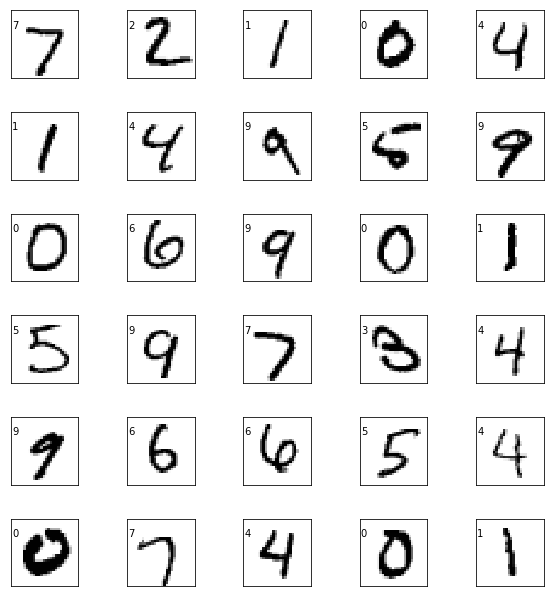

---------------------------------------------------


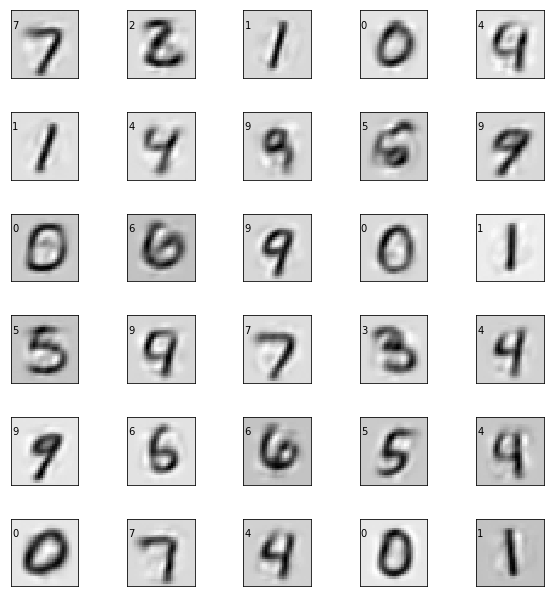

In [87]:
#Test Processing:
output = []
with tf.Session() as sess:
    if os.path.exists('tmpnn/checkpoint'):        
        saver.restore(sess, 'tmpnn/model.ckpt')
        total_batch  = int(len(test_images)/batch_size)
        msg = "Test batch={:d}, lose={:.4f}"
        for b in tqdm(range(total_batch)):
            batch = test_images[b*batch_size:(b+1)*batch_size]
            imgs = batch.reshape((-1,28,28,1))
            cost,out = sess.run([loss,y_pred], feed_dict={X:batch})
            output.append(out)
            print(msg.format(b,cost))

    else :
        print("Please run training part first")
    fig1 = plt.figure(figsize=(8,8))
    fig1.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)
    for i in range(30):
        image = np.reshape(test_images[i],[28,28])
        ax=fig1.add_subplot(6,5,i+1,xticks=[],yticks=[]) 
        ax.imshow(image,cmap=plt.cm.binary,interpolation='nearest') 
        ax.text(0,7,str(test_labels[i]))
    plt.show()
    print("---------------------------------------------------")
    fig = plt.figure(figsize=(8,8))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)
    for i in range(30):
        image = np.reshape(output[0][i],[28,28])
        ax=fig.add_subplot(6,5,i+1,xticks=[],yticks=[]) 
        ax.imshow(image,cmap=plt.cm.binary,interpolation='nearest') 
        ax.text(0,7,str(test_labels[i]))
    plt.show()